In [1]:
from Model import Generator, Discriminator
import os
import numpy as np
import math
import time
import random
from collections import defaultdict
from pathlib import Path
from Model import Generator

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt

/home/ziyue/.conda/envs/raingan/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose([
  transforms.ToTensor()
])

class rain(Dataset):

    def __init__(self, input_dir, output_dir, transform=transform):
        self.input_dir = Path(input_dir)
        self.output_dir = Path(output_dir)
        self.input = np.load(self.input_dir)
        self.output = output = np.load(self.output_dir)
        self.transform = transform

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):   #idx就是来选取第几个的那个index
        input = self.input[idx]
        output = self.output[idx] 

        if self.transform:
            input = self.transform(input)  #torch的tensor和np实际上是反过来的，我们需要改动一下
            output = self.transform(output)

        return input, output


in_dir = 'paddedinput_30mins_4ch.npy'
out_dir = 'paddedoutput_30mins_4ch.npy'
val_percent: float = 0.2 #Use 20% as validation dataset
batch_size = 16

dataset = rain(in_dir, out_dir, transform)     #创造一个dataset，用我上面自定义的dataset class

n_val = int(len(dataset) * val_percent)   #这几行就是定义多少个training 多少个validation
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(42))

#验证一下dataset是不是我想的那样
'''
input, output = dataset[0]  #打印第0个element of dataset
print(type(input))   # --> <class 'torch.Tensor'>
print(input.size())   # --> torch.Size([4, 192, 128])
print(output.size())   # --> torch.Size([1, 192, 128])
plt.imshow(input[:,:,0]) # --> 应该打出来不对的，因为现在是channel开头了，不是channel最后了，transform的作用
'''

#Dataloader了该 Dataloader的作用就是打包Batch
loader_args = dict(batch_size=batch_size, num_workers=4, pin_memory=True) #为下面的两行做准备
#train_loader = DataLoader(train_set, shuffle=True, **loader_args)   #dataloader来load这个dataset，分为train和validation
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

####################################


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
generator = Generator().to(device)
generator.load_state_dict(torch.load('generator.pth'))
generator.eval()

def depad(pred, from_shape_w=192, to_shape_w=180, from_shape_h=128, to_shape_h=120):
    padding_w = int( (from_shape_w - to_shape_w) / 2)
    padding_h = int( (from_shape_h - to_shape_h) / 2)
    return pred[padding_w:padding_w+to_shape_w, padding_h:padding_h+to_shape_h].copy()

#Takes a batch of 16 as prediction/ground truth, select which frame from the batch to be plotted
def plot(prediction, ground, frame):

    fig = plt.figure(figsize=(9,6))

    fig.add_subplot(121)
    pred_image = depad(prediction[frame,0,:,:])
    plt.title("Prediction", fontsize = 30)
    plt.imshow(pred_image, cmap = 'jet', vmax = 10, vmin = 0)

    fig.add_subplot(122)
    
    output_image = depad(ground[frame,0,:,:])
    plt.title("Ground Truth", fontsize = 30)
    plt.imshow(output_image, cmap = 'jet', vmax = 10, vmin = 0)

    fig.tight_layout()



#This function picks up the nth batch from the validation dataset (val_loader)
def select_batch(batch_num):
    if batch_num >= len(val_loader): return -1    #if we dont have that much batch in val dataset, we should return error

    i = 0
    for data in iter(val_loader):
        input, output = data
        #print(x.size())
        if i >= batch_num: break    #define which batch (with size 16 in each) to see
        i += 1
    return input, output


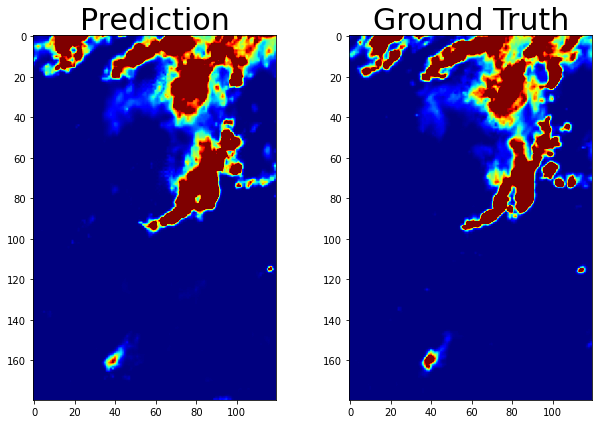

In [4]:
input, output = select_batch(0)

input = input.to(device).float()
output = output.to(device).float()

pred = generator(input)
pred = pred.data.cpu().numpy()
input = input.data.cpu().numpy()
output = output.data.cpu().numpy()

plot(pred, output, frame = 4)